In [1]:
## Do
# plot contribution to j0rad integral --> rewrite j0_rad function
# modify V_loss_Rau outputs, so it gives all voltages (Eref,Voc_SQ,Voc_jsc,Voc_rad,Voc) and all Deltas (Delta_SQ,Delta_jsc,Deta_rad,Delta_nonrad)
#find AM1.5 file difficult

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy import integrate as ig
from scipy.interpolate import interp1d
from functions import J0, J0_rad, SQ, Voc_rad, LED_QE, calculate_summary, Vloss_CT, Vloss_SQ, calculate_Jsc
from utils import bb, getAM15, linear, set_up_plot
from utils_EQE import extend_EQE
from utils_EQE import Marcus_Gaussian

In [2]:
T = 293 # [K] ambient & cell temperature
h = 6.626 * 10**(-34) # [kgm^2/s]
h_eV = 4.1357*10**(-15) # eV s
c = 2.998 * 10**(8) # [m/s]
k = 1.3806 * 10**(-23) # [kgm^2/s^2K]
k_eV = 8.6173*10**(-5) # eV / K
q = 1.60217662 * 10**(-19) # [C]
q_eV = 1
Vth = k_eV*T/q_eV # thermal voltage [eV]

In [3]:
codePath = os.getcwd()#only makes sense after kernel restart
codePath

'C:\\Users\\pasca\\Documents\\GitHub\\Voltage-Loss-Calculations'

In [4]:
os.chdir('C:/Users/pasca/OneDrive - Nexus365/Post/data/')#/home/jungbluth/Desktop/
os.getcwd()

'C:\\Users\\pasca\\OneDrive - Nexus365\\Post\\data'

## generate EQE from  Marcus parameters

In [49]:
EQE_folder = r'C:\Users\pasca\OneDrive - Nexus365\Post\projects\_MY-SAMPLES\mobombination\Vloss'
EQE_file = r'HB194_A7_50nm'

os.chdir(codePath) 
E_extrap = np.arange(1,2.5,0.005)
E_CT = 1.618
l_CT = 0.334
f_CT = 0.155
Temperature = 295
EQE_fit = Marcus_Gaussian(E_extrap, E_CT, l_CT,f_CT, np.nan, np.nan, np.nan, Temperature)

EQE_fit_export = pd.DataFrame()
EQE_fit_export['Energy'] = EQE_fit['Energy']
EQE_fit_export['Signal']= EQE_fit['EQE (CT)']
EQE_fit_export['Temperature'] = Temperature
EQE_fit_export['Oscillator Strength (eV**2)'] = f_CT
EQE_fit_export['Reorganization Energy (eV)'] = l_CT
EQE_fit_export['CT State Energy (eV)'] = E_CT

save_path = os.path.join(EQE_folder, EQE_file + '_CT-fit')
EQE_fit_export.to_csv(save_path)

### additional functions

In [5]:
# Radiative limit of saturation current density
def J0_rad_alt(EQE_df, phi_bb_df):
    """
    Function to calculate the radiative limit of the saturation current density (J0,rad)
    :param EQE_df: dataFrame of EQE spectra, with columns 'Energy' and 'EQE' [dataFrame of floats]
    :param phi_bb_df: dataFrame of black-body spectrum, with columns 'Energy' and 'Phi' [dataFrame of floats]
    :return: J0_rad: radiative limit of the saturation current density [float]
    """
    
    #EQE_intp = interp1d(EQE_df['Energy'].values, EQE_df['EQE'].values)
    #Phi_intp = interp1d(phi_bb_df['Energy'].values, phi_bb_df['Phi'].values)

    J0_rad_integral = q/10*ig.simps(EQE_df['EQE'].values*phi_bb_df['Phi'].values,EQE_df['Energy'].values)
    #ig.simps(AM15flux[energy>=Eg],energy[energy>=Eg])
    ##plt.semilogy(EQE_df['Energy'].values,EQE_df['EQE'].values*phi_bb_df['Phi'].values)
    ##plt.semilogy(EQE_df['Energy'].values,EQE_df['EQE'].values)
    ##plt.xlim([0.8,2])
    ##plt.ylim([1e-6,1e6])
    #result = ig.quad(lambda e: q*EQE_intp(e)*Phi_intp(e), min(EQE_df['Energy']), max(EQE_df['Energy']))
    #J0_rad_integral = result[0]/10 # result[0] = integral result, result[1] = estimate of the absolute error on the result
    return J0_rad_integral

In [ ]:
#def getAM15():
    #filePath = codePath + '\ASTMG173.csv'# 1:wavelength [nm], 3:AM15g spectral power [W/(m^2nm)]
    

# calc & plot Voc,rad contributions

In [12]:
#loading flips the data!
##VTE
#binFile = r'C:\Users\pasca\OneDrive - Nexus365\Post\projects\_MY-SAMPLES\mobombination\Vloss\bins_Vloss_sel-fitted.csv'
##NFA bilayer
binFile = r'C:\Users\pasca\OneDrive - Nexus365\Post\projects\_MY-SAMPLES\mobombination\Vloss\bins_Vloss_sel-fitted.csv'
df = pd.read_csv(binFile, sep = ',') #uses .csv headers as column labels 
#row = df.loc[9]#thin2,4,8 #thick3,5,9
row = df.loc[4]
EQE_file = row['EQE_folder'] + '\\' + row['EQE_file']
EQEdata = np.genfromtxt(EQE_file, skip_header = 1, delimiter = ',')
EQE_df = pd.DataFrame()
EQE_df['Energy'] = np.flip(EQEdata[:,2])
EQE_df['EQE'] = np.flip(EQEdata[:,3])*row['EQE_fac']
os.chdir(codePath) 
phi_bb_df = bb(EQE_df['Energy'])

Jsc_EQE = calculate_Jsc(EQE_df['Energy'],EQE_df['EQE'])
J0rad_EQE_alt = J0_rad_alt(EQE_df, phi_bb_df)
Voc_rad_alt = k*T/q * np.log((Jsc_EQE/J0rad_EQE_alt )+1)

#cumulative sum (contribution to integral, lower boundary varied for *_rev) 
J0_rad_cum_rev = -q/10*ig.cumulative_trapezoid(np.flip(EQE_df['EQE'].values*phi_bb_df['Phi'].values),np.flip(EQE_df['Energy'].values))
Voc_rad_cum = k*T/q * np.log((Jsc_EQE/J0_rad_cum_rev )+1)
####J0_rad_cum = q/10*ig.cumulative_trapezoid(EQE_df['EQE'].values*phi_bb_df['Phi'].values,EQE_df['Energy'].values)
##

C:\Users\pasca\Documents\GitHub\Voltage-Loss-Calculations\functions.py:61: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = ig.quad(lambda e: q*EQE_intp(e)*AM15_intp(e), min(E), max(E))


In [13]:
df_Vocrad = pd.DataFrame()
df_Vocrad['Emin'] = np.flip(EQE_df.loc[1:,'Energy'].values)
df_Vocrad['Vocrad'] = Voc_rad_cum
save_dir = r'C:\Users\pasca\OneDrive - Nexus365\Post\projects\_MY-SAMPLES\mobombination\Vloss\res'
save_path = os.path.join(save_dir, 'Vocrad_contrib_' + row['run'] + '.csv')
df_Vocrad.to_csv(save_path)

5.049670652685436e-22
1.2870362323004734


Text(0.5, 0, 'lower boundary of integral E_min [eV]')

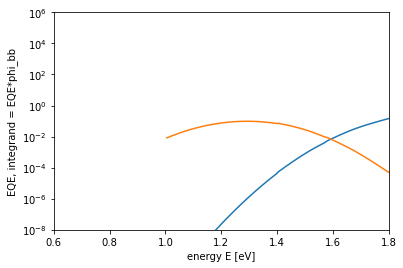

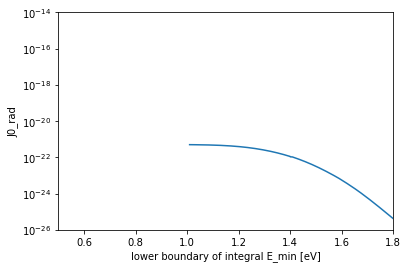

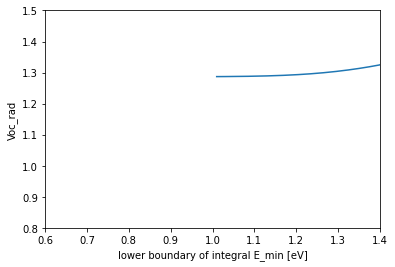

In [14]:
## plot Vocrad contributions
print(J0rad_EQE_alt )
print(Voc_rad_alt)

plt.figure(1)
plt.semilogy(EQE_df['Energy'].values, EQE_df['EQE'].values)
plt.semilogy(EQE_df['Energy'].values, EQE_df['EQE'].values*phi_bb_df['Phi'].values)
plt.ylim([1e-8,1e6])
plt.xlim([0.6,1.8])
plt.ylabel('EQE, integrand = EQE*phi_bb')
plt.xlabel('energy E [eV]')

plt.figure(2)
plt.semilogy(np.flip(EQE_df.loc[1:,'Energy'].values),J0_rad_cum_rev)
plt.xlim([0.5,1.8])
plt.ylim([1e-26,1e-14])
plt.ylabel('J0_rad')
plt.xlabel('lower boundary of integral E_min [eV]')

plt.figure(3)
plt.plot(np.flip(EQE_df.loc[1:,'Energy'].values),Voc_rad_cum)
plt.xlim([0.6,1.4])
plt.ylim([0.8,1.5])
plt.ylabel('Voc_rad')
plt.xlabel('lower boundary of integral E_min [eV]')

## extrapolation attempt? 

In [ ]:
#loading doesn't flip the data!
binFile = r'C:\Users\pasca\OneDrive - Nexus365\Post\projects\_MY-SAMPLES\mobombination\Vloss\bins_Vloss_sel-fitted.csv'
df = pd.read_csv(binFile, sep = ',') #uses .csv headers as column labels 
row = df.loc[0]
EQE_file = row['EQE_folder'] + '\\' + row['EQE_file']
EQEdata = np.genfromtxt(EQE_file, skip_header = 1, delimiter = ',')
EQE_df = pd.DataFrame()
EQE_df['Energy'] = EQEdata[:,2]
EQE_df['EQE'] = EQEdata[:,3]*row['EQE_fac']
os.chdir(codePath) 
phi_bb_df = bb(EQE_df['Energy'])

In [ ]:
#'linear' extrapolation --> not successful
EQE_extrap = extend_EQE(EQE_df, 'linear', min_energy=0.8, start = 1.3, stop = 1.4)
phi_bb_df_etrap = bb(EQE_extrap['Energy'])
#plt.figure(11)
#plt.plot(EQE_extrap['Energy'])
#plt.figure(12)
#plt.semilogy(EQE_extrap['EQE'])
plt.figure(10)
plt.semilogy(EQE_extrap['Energy'],EQE_extrap['EQE'])

In [ ]:
# 'gaussian' extrapolation
## equivalent to sitiching fit & data

In [ ]:
plt.figure(0)
plt.semilogy(EQE_df['Energy'].values, EQE_df['EQE'].values)
plt.semilogy(EQE_df['Energy'].values, EQE_df['EQE'].values*phi_bb_df['Phi'].values)
###
plt.semilogy(EQE_extrap['Energy'].values, EQE_extrap['EQE'].values)
plt.semilogy(EQE_extrap['Energy'].values, EQE_extrap['EQE'].values*phi_bb_df_etrap['Phi'].values)
plt.ylim([1e-14,1e6])
plt.xlim([0.5,2])
plt.ylabel('EQE, integrand = EQE*phi_bb')
plt.xlabel('energy E [eV]')

In [46]:
EQE_fit_export

,Energy,Signal,Temperature,Oscillator Strength (eV**2),Reorganization Energy (eV),CT State Energy (eV)
0,1.000,1.221580e-12,295,0.155,0.334,1.618
1,1.005,1.607581e-12,295,0.155,0.334,1.618
2,1.010,2.112492e-12,295,0.155,0.334,1.618
3,1.015,2.771971e-12,295,0.155,0.334,1.618
4,1.020,3.632064e-12,295,0.155,0.334,1.618
...,...,...,...,...,...,...
295,2.475,6.094497e-05,295,0.155,0.334,1.618
296,2.480,5.210306e-05,295,0.155,0.334,1.618
297,2.485,4.447859e-05,295,0.155,0.334,1.618
298,2.490,3.791413e-05,295,0.155,0.334,1.618


## Calculate Voc losses

In [6]:
##VTE
#binFile = r'C:\Users\pasca\OneDrive - Nexus365\Post\projects\_MY-SAMPLES\mobombination\Vloss\bins_Vloss_sel-fitted.csv'
##NFA bilayer
binFile = r'C:\Users\pasca\OneDrive - Nexus365\Post\projects\_MY-SAMPLES\mobombination\Vloss\bins_Vloss_sel-fitted.csv'
df = pd.read_csv(binFile, sep = ',') #uses .csv headers as column labels    
df['Voc_SQ']=np.nan
df['Voc_sc']=np.nan
df['Voc_rad']=np.nan
##
#df['Voc_rad_alt']=np.nan
##
df['Delta_V_SQ'] = np.nan
df['Delta_V_sc']=np.nan
df['Delta_V_rad']=np.nan
df['Delta_V_nonrad']=np.nan
df['Q_LED']=np.nan

for ind, row in df.iterrows():
    EQE_file = row['EQE_folder'] + '\\' + row['EQE_file']
    EQEdata = np.genfromtxt(EQE_file, skip_header = 1, delimiter = ',')
    EQE_df = pd.DataFrame()
    EQE_df['Energy'] = np.flip(EQEdata[:,2])
    EQE_df['EQE'] = np.flip(EQEdata[:,3])*row['EQE_fac']
    os.chdir(codePath)  
    phi_bb_df = bb(EQE_df['Energy'])
    Jsc_EQE = calculate_Jsc(EQE_df['Energy'],EQE_df['EQE'])
    ##
    J0rad_EQE = J0_rad(EQE_df, phi_bb_df)
    vocrad,temp = Voc_rad(row['Voc'], Jsc_EQE, J0rad_EQE)
    df.at[ind,'Voc_rad'] = vocrad
    
    #J0rad_EQE_alt = J0_rad_alt(EQE_df, phi_bb_df)
    #vocrad,temp = Voc_rad(row['Voc'], Jsc_EQE, J0rad_EQE_alt)
    #df.at[ind,'Voc_rad_alt'] = vocrad        
    ##
    df.at[ind,'Voc_SQ'], df.at[ind,'Delta_V_sc'], df.at[ind,'Delta_V_rad'], df.at[ind,'Delta_V_nonrad'] = Vloss_SQ(row['Eg'], row['Voc'], row['Jsc'], voc_rad = vocrad)#
df['Voc_sc'] = df['Voc_SQ'] - df['Delta_V_sc']
df['Delta_V_SQ'] = df['Eg'] - df['Voc_SQ']
for ind, row in df.iterrows():
    df.at[ind,'Q_LED'] = LED_QE( row['Delta_V_nonrad'])

C:\Users\pasca\Documents\GitHub\Voltage-Loss-Calculations\functions.py:61: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = ig.quad(lambda e: q*EQE_intp(e)*AM15_intp(e), min(E), max(E))
C:\Users\pasca\Documents\GitHub\Voltage-Loss-Calculations\functions.py:61: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

In [7]:
df

,run,substrate,pixel,description,EQE_folder,EQE_file,EQE_fac,Eg,Jsc,Voc,Voc_SQ,Voc_sc,Voc_rad,Delta_V_SQ,Delta_V_sc,Delta_V_rad,Delta_V_nonrad,Q_LED
0,PK210212_DCV5T-C60,C,4,"RT,50nm",C:\Users\pasca\OneDrive - Nexus365\Post\projec...,DCV5T_C4_RT_50nm_stitched.csv,1,1.83,10.0,0.961,1.548568,1.532647,1.290907,0.281432,0.015921,0.241740,0.329907,2.114443e-06
1,PK210218_ZnPc-C60,A,5,"RT,50nm",C:\Users\pasca\OneDrive - Nexus365\Post\projec...,ZnPc_A5_RT_50nm_stitched.csv,1,1.65,5.9,0.477,1.379474,1.344027,0.943616,0.270526,0.035447,0.400411,0.466616,9.410981e-09
2,PK210226_F4ZnPc-C60,A,5,"RT,50nm",C:\Users\pasca\OneDrive - Nexus365\Post\projec...,F4ZnPc_A5_RT_50nm_stitched.csv,1,1.64,6.3,0.732,1.369265,1.335095,1.117038,0.270735,0.034170,0.218057,0.385038,2.381620e-07
3,DTDCPB-C60,A,7,50nm,C:\Users\pasca\OneDrive - Nexus365\Post\projec...,DTDCPB_A1_50nm_stitched.csv,1,1.75,7.5,0.942,1.473443,1.447424,1.214085,0.276557,0.026019,0.233339,0.272085,2.088397e-05
4,HB194-C60,A,1,50nm,C:\Users\pasca\OneDrive - Nexus365\Post\projec...,HB194_A7_50nm_stitched.csv,1,1.88,9.6,0.939,1.595346,1.580298,1.286832,0.284654,0.015048,0.293466,0.347832,1.039600e-06


## Save V loss calculations

In [8]:
###VTE
#save_dir = r'C:\Users\pasca\OneDrive - Nexus365\Post\projects\_MY-SAMPLES\mobombination\Vloss\res'
##NFA bilayer
save_dir = r'C:\Users\pasca\OneDrive - Nexus365\Post\projects\_MY-SAMPLES\bilayer_solution\DataAnalysis\Vloss\res'
save_path = os.path.join(save_dir, 'VlossAnalysis_211031.csv')
df.to_csv(save_path)
 